In [1]:
# For Google Colab use
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd '/content/drive/MyDrive/Colab Notebooks/MInf2 Colab/_TRAINING/ViT'    
except ModuleNotFoundError:
    pass

In [2]:
!pip install tensorflow-addons
!pip install vit-keras

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score
from vit_keras import vit, utils
from datetime import datetime
import seaborn as sns
import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import seaborn as sns
import re
import ast
import os
import cv2
import random


# Plotting parameters
sns.set()
plt.rc('font', family = 'serif')
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20 

In [4]:
# Helper Functions

def get_binary_testset(dataset_name):
    """
    dataset_name -> trainset, valset, testset
    """
    trainset, valset, testset = None, None, None
    dataset_name = dataset_name.lower()
    path_2_root = "../.."

    if not "oc" in dataset_name:
        if "dar" in dataset_name and "oc" not in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/train_test"
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/validation"

        if "avg" in dataset_name: # Celeb-avg-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_avg"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_avg"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_avg"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_avg"

        elif "rnd" in dataset_name: # Celeb-rnd-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_rnd"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_rnd"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_rnd"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_rnd"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_rnd"

        elif "diff" in dataset_name: # Celeb-diff-30
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30"
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

    else: # oc
        if "dar" in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/real-train/" # unary
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/realfake-test/" # binary

        elif "avg" in dataset_name:
            pass

        elif "rnd" in dataset_name: # Celeb-rnd-30-OC
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-train/" # unary
            valset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-val/"  # unary
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/" # binary

    testset = trainset if testset==None else testset
    valset = trainset if valset==None else valset
    return trainset, valset, testset




def current_datetime_string():
    """
    'ddmm_hhmm'
    """
    date_of_run = str(datetime.now())
    for s in ("-", " ", ":", "_"):
        date_of_run = date_of_run.replace(s, "_") 
    date_of_run = "".join(date_of_run.split("_")[1:3] + ["_"] + date_of_run.split("_")[3:-1])
    return date_of_run



def eval_model_w_gen(EVAL_GEN, avg_eval=False):
    y_pred = []
    y_true = []
    CLASSIFIER = VIT_FE
    if avg_eval:
        # running average eval, set of images from each video is single data point (not indep.)
        path_to_testset_real_class = f"{TEST_DATASET}/{[d for d in os.listdir(TEST_DATASET) if 'real' in d][0]}"
        path_to_testset_fake_class = f"{TEST_DATASET}/{[d for d in os.listdir(TEST_DATASET) if 'real' not in d][0]}"

        for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
            img_dir_list = os.listdir(y_dir_pth)
            Vpths = []
            # loop over all single videos
            for og_fname in set([re.split('_\d+.png', img_name)[0] for img_name in img_dir_list]):

                all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
                path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
                V = []

                # loop over all frames from single video
                for path_to_test_img in path_all_imgs_for_vid:
                    t = load_img(path_to_test_img, target_size=(IMAGE_SIZE, IMAGE_SIZE))
                    t = img_to_array(t)
                    # V += [t]
                    V += [vit.preprocess_inputs(t)]
                V = np.array(V)#**1./255
                
                y_pred += [np.average(CLASSIFIER.predict(V)).tolist()]
                y_true += [y_label]
    else:
        for b, (X, y) in tqdm(enumerate(EVAL_GEN), total=len(EVAL_GEN)-1):
            y_pred += CLASSIFIER.predict(X).tolist() 
            y_true += y.tolist()
            # break
            if b >= (EVAL_GEN.samples / EVAL_GEN.batch_size) - 1:
                break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_rint = np.rint(y_pred)
    return y_true, y_pred, y_pred_rint




def plot_history():
    fig, (ax1, ax2) = plt.subplots(2, figsize = (10, 10), sharex=True)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(f'{experiment_name} Training/Validation Losses')
    ax1.set_ylabel('Loss')
    ax1.legend(['Training Loss', 'Validation Loss'], loc='center right')

    ax2.plot(history.history['auc'])
    ax2.plot(history.history['val_auc'])
    ax2.set_title(f'{experiment_name} Training/Validation AUCs')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Training AUC', 'Validation AUC'], loc='upper right')
    plt.savefig(f"./Results/{fname}_Losses.pdf", dpi=fig.dpi)
    plt.show()




def save_statstxt_aucplot(is_running_avg_eval=False):
    y_true, y_pred, y_pred_rint = eval_model_w_gen(EVAL_GEN=TEST_GEN, avg_eval=is_running_avg_eval)
    auroc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _  = roc_curve(y_true, y_pred)

    # If model is worse than random but so much worse that, it's predicting the opposite way
    if auroc < .5:
        auroc = 1 - auroc
        fpr, tpr = tpr, fpr
        y_pred = np.ones(y_pred.shape) - y_pred

    # Get F1, Precision and Recall
    f1 = f1_score(y_true, y_pred_rint)
    prec = precision_score(y_true, y_pred_rint)
    recall = recall_score(y_true, y_pred_rint)

    # Plot AUC
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Test AUROC {experiment_name}")
    plt.legend(loc="lower right")
    plt.savefig(f"./Results/{fname}_AUC.pdf")
    plt.show()

    with open(f"./Results/{fname}.txt", "w") as f:
        f.write(f"{experiment_name, model_name, dataset_name, fname}\n")
        f.write(f"auroc={auroc}\n")
        f.write(f"f1={f1}\n")
        f.write(f"prec={prec}\n")
        f.write(f"recall={recall}\n")
        f.write(f"\nfpr={[f for f in fpr]}\n")
        f.write(f"\ntpr={[t for t in tpr]}\n")
        f.write(f"\ny_true={[t for t in y_true]}\n")
        f.write(f"\ny_pred={[p[0] if 'arr' in str(type(p)) and len(p) else p for p in y_pred]}\n")
        try:
            f.write(f"\nhistory={history}")
        except NameError:
            pass




class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    # Some code is taken from:
    # https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [5]:
model_name = "ViT"
experiment_name = f"{model_name} (RND CDFv2 Dataset)" # CHANGE THESE
dataset_name = "Celeb-rnd-30"                   # CHANGE THESE
dataset_type = "AVG" if "AVG" in dataset_name.upper() else "RND"
fname = f"ViT_{dataset_name.replace('-', '_')}_{current_datetime_string()}"

In [6]:
DATASET, VAL_DATASET, TEST_DATASET = get_binary_testset(dataset_name)

BATCH_SIZE = 64
SEED = 42
IMAGE_SIZE = 256 #16x16 (IMAGE_SIZE % == 0 = True, because patches)
EPOCHS = 100-68
LEARNING_RATE = 5e-3

keras.utils.set_random_seed(SEED)
path_2_weights_dir = f"../../_WEIGHTS/vit/{fname}"

print(f"""
BATCH_SIZE={BATCH_SIZE}
SEED={SEED}
IMAGE_SIZE={IMAGE_SIZE}
EPOCHS={EPOCHS}
LEARNING_RATE={LEARNING_RATE}
DATASET={DATASET}
VAL_DATASET={VAL_DATASET}
TEST_DATASET={TEST_DATASET}
path_2_weights_dir={path_2_weights_dir}
""")


BATCH_SIZE=64
SEED=42
IMAGE_SIZE=256
EPOCHS=32
LEARNING_RATE=0.005
DATASET=../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30
VAL_DATASET=../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30
TEST_DATASET=../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test
path_2_weights_dir=../../_WEIGHTS/vit/ViT_Celeb_rnd_30_0225_1159



In [7]:
IMG_DATAGEN = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=vit.preprocess_inputs,
)

GEN = IMG_DATAGEN.flow_from_directory(
    DATASET,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    subset="training",
    class_mode="binary",
    )

VAL_GEN = None
test_split = None
has_test_set = TEST_DATASET != DATASET
if has_test_set:
    # When there's a test set, we can create a validation set using the train set
    # However, when there's no test set (i.e. we just have 2 folders: real/fake)
    # We have to create a validation set using `validation_split` in fit()"
    # And we have to test using the ImageDataGenerator `validation_split`
    # Ensuring non overlapping train/val/test sets`
    print("There's a test set, so creating val set using train set")
    VAL_GEN = IMG_DATAGEN.flow_from_directory(
        VAL_DATASET,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=SEED,
        subset="validation",
        class_mode="binary",
        )
else: 
    print("There's no test set, SPECIFY `validation_split` in fit()")
    test_split = 0.2

# SPECIFY VAL SPLIT IN FIT FUNC
TEST_GEN = IMG_DATAGEN.flow_from_directory(
    TEST_DATASET,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    subset=None if has_test_set else "validation", # there no test set 
    class_mode="binary",
    )

Found 44393 images belonging to 2 classes.
There's a test set, so creating val set using train set
Found 11097 images belonging to 2 classes.
Found 19638 images belonging to 2 classes.


In [8]:
total_steps = int((GEN.n//GEN.batch_size) * EPOCHS)
warmup_epoch_percentage = 0.2
warmup_steps = int(total_steps * warmup_epoch_percentage)
SCHEDULED_LRS = WarmUpCosine(learning_rate_base=LEARNING_RATE,
                             total_steps=total_steps,
                             warmup_learning_rate=0,
                             warmup_steps=warmup_steps)
# plt.plot([SCHEDULED_LRS(step) for step in range(total_steps)])
# plt.title("Learning Rate Schedule")
# plt.xlabel("Step", fontsize=14)
# plt.ylabel("LR", fontsize=14)
# plt.show()

EARLY_STOP = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=EPOCHS//10,
    verbose=1,
    restore_best_weights=True,
    )

MODEL_CHECKPOINT = ModelCheckpoint(
    filepath = path_2_weights_dir, 
    mode='max', 
    monitor='val_auc', 
    save_freq='epoch',
    verbose=1, 
    save_best_only=True,
    save_weights_only=True,
    )

In [9]:
PRE_TRAINED_MODEL = vit.vit_b16(
    image_size=IMAGE_SIZE,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

for layer in PRE_TRAINED_MODEL.layers:
    layer.trainable = False

x = layers.Flatten()(PRE_TRAINED_MODEL.output)
x = layers.Dense(1, activation = 'sigmoid')(x)

VIT_FE = Model(PRE_TRAINED_MODEL.input, x) # Vision Transformer Feature Extractor

VIT_FE.compile(
    optimizer = keras.optimizers.SGD(learning_rate=SCHEDULED_LRS, momentum=0.9),
    loss = 'binary_crossentropy',
    metrics = [metrics.AUC(name = 'auc')])
VIT_FE.summary()

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 256, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 257, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 257, 768)         197376    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 257, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))        

In [12]:
celeb_rnd_weights_epoch_47 = '../../_WEIGHTS/vit/Celeb-rnd-30-train_E100'
celeb_rnd_weights_epoch_54 = '../../_WEIGHTS/vit/ViT_Celeb_rnd_30_0223_1926'
celeb_rnd_weights_epoch_58 = '../../_WEIGHTS/vit/ViT_Celeb_rnd_30_0224_1600'
celeb_rnd_weights_epoch_68 = "../../_WEIGHTS/vit/ViT_Celeb_rnd_30_0224_1933"
celeb_rnd_best_weights = "../../_WEIGHTS/vit/ViT_Celeb_rnd_30_0224_2353"
VIT_FE.load_weights(celeb_rnd_best_weights)


In [ ]:
# history = VIT_FE.fit(
#     GEN,
#     validation_data = VAL_GEN, 
#     validation_split=test_split,
#     epochs = EPOCHS,
#     verbose = 1,
#     callbacks = [
#         EARLY_STOP,
#         MODEL_CHECKPOINT,
#     ]
#     )

Epoch 1/32
694/694 [==============================] - ETA: 0s - loss: 0.2387 - auc: 0.8507
Epoch 1: val_auc improved from -inf to 0.71068, saving model to ../../_WEIGHTS/vit\ViT_Celeb_rnd_30_0224_2353
694/694 [==============================] - 1245s 2s/step - loss: 0.2387 - auc: 0.8507 - val_loss: 0.3259 - val_auc: 0.7107
Epoch 2/32
694/694 [==============================] - ETA: 0s - loss: 0.2389 - auc: 0.8510
Epoch 2: val_auc did not improve from 0.71068
694/694 [==============================] - 1027s 1s/step - loss: 0.2389 - auc: 0.8510 - val_loss: 0.3259 - val_auc: 0.7107
Epoch 3/32
694/694 [==============================] - ETA: 0s - loss: 0.2376 - auc: 0.8527
Epoch 3: val_auc did not improve from 0.71068
694/694 [==============================] - 1034s 1s/step - loss: 0.2376 - auc: 0.8527 - val_loss: 0.3259 - val_auc: 0.7107
Epoch 4/32
694/694 [==============================] - ETA: 0s - loss: 0.2398 - auc: 0.8486Restoring model weights from the end of the best epoch: 1.

Epoch 

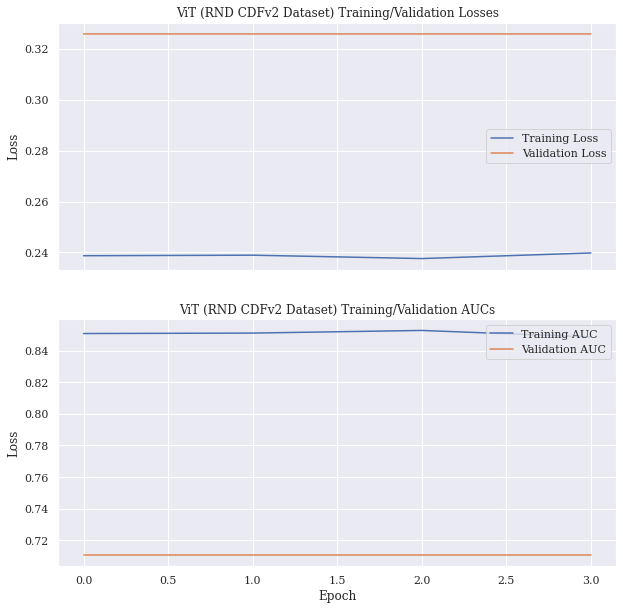

100%|██████████| 306/306 [09:05<00:00,  1.78s/it]


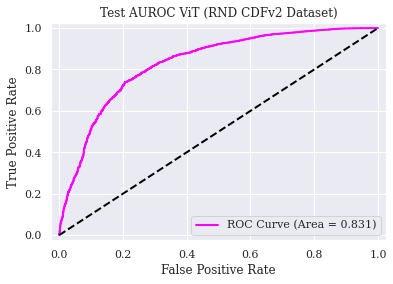

In [ ]:
# plot_history()
# save_statstxt_aucplot()

In [ ]:
#               # experiment_name,                                       model_name,          testset_name,                 fname
# EXPERIMENTS = [(f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on DFDB Dataset",  f"ViT_{dataset_type}", "Celeb-avg-30", f"ViT_{dataset_type}_onDFDB"),

#                 # ViT RND on Celebs indep eval
#                (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on AVG CDFv2 Dataset",  f"ViT_{dataset_type}", "Celeb-avg-30", f"ViT_{dataset_type}_onAVG"),

#                (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on RND CDFv2 Dataset",  f"ViT_{dataset_type}", "Celeb-rnd-30", f"ViT_{dataset_type}_onRND"),

#                 # ViT RND on Celebs rae
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on AVG CDFv2 Dataset\
#                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Celeb-avg-30", f"ViT_{dataset_type}_raeonAVG"),

#                (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on RND CDFv2 Dataset\
#                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Celeb-rnd-30", f"ViT_{dataset_type}_raeonRND"),

#                 # ViT RND on FF indep eval
#                 # DF
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on AVG Deepfakes Dataset\
#                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Deepfakes_avg", f"ViT_{dataset_type}_raeonDFavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on AVG Deepfakes Dataset",  f"ViT_{dataset_type}", "Deepfakes_avg", f"ViT_{dataset_type}_DFavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on RND Deepfakes Dataset\
#                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Deepfakes_rnd", f"ViT_{dataset_type}_raeonDFrnd"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                \nTested on RND Deepfakes Dataset",  f"ViT_{dataset_type}", "Deepfakes_rnd", f"ViT_{dataset_type}_DFrnd"),

#                 # F2F
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG Face2Face Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Face2Face_avg", f"ViT_{dataset_type}_raeonF2Favg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG Face2Face Dataset",  f"ViT_{dataset_type}", "Face2Face_avg", f"ViT_{dataset_type}_F2Favg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND Face2Face Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Face2Face_rnd", f"ViT_{dataset_type}_raeonF2Frnd"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND Face2Face Dataset",  f"ViT_{dataset_type}", "Face2Face_rnd", f"ViT_{dataset_type}_F2Frnd"),

#                 # FaceShifter
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG FaceShifter Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceShifter_avg", f"ViT_{dataset_type}_raeonFSHFTavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG FaceShifter Dataset",  f"ViT_{dataset_type}", "FaceShifter_avg", f"ViT_{dataset_type}_FSHFTavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND FaceShifter Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceShifter_rnd", f"ViT_{dataset_type}_raeonFSHFTrnd"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND FaceShifter Dataset",  f"ViT_{dataset_type}", "FaceShifter_rnd", f"ViT_{dataset_type}_FSHFTrnd"),

#                 # FaceSwap
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG FaceSwap Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceSwap_avg", f"ViT_{dataset_type}_raeonFSavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG FaceSwap Dataset",  f"ViT_{dataset_type}", "FaceSwap_avg", f"ViT_{dataset_type}_FSavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND FaceSwap Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceSwap_rnd", f"ViT_{dataset_type}_raeonFSrnd"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND FaceSwap Dataset",  f"ViT_{dataset_type}", "FaceSwap_rnd", f"ViT_{dataset_type}_FSrnd"),

#                 # NeuralTextures
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG NeuralTextures Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "NeuralTextures_avg", f"ViT_{dataset_type}_raeonNTavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on AVG NeuralTextures Dataset",  f"ViT_{dataset_type}", "NeuralTextures_avg", f"ViT_{dataset_type}_NTavg"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND NeuralTextures Dataset\
#                 \nRunning Average Evaluation",  f"ViT_{dataset_type}", "NeuralTextures_rnd", f"ViT_{dataset_type}_raeonNTrnd"),
#                 (f"ViT ({dataset_type} CDFv2 Dataset)\
#                 \nTested on RND NeuralTextures Dataset",  f"ViT_{dataset_type}", "NeuralTextures_rnd", f"ViT_{dataset_type}_NTrnd"),

#                ]


In [13]:
              # experiment_name,                                       model_name,          testset_name,                 fname
EXPERIMENTS = [(f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on DFDB Dataset",  f"ViT_{dataset_type}", "Celeb-avg-30", f"ViT_{dataset_type}_onDFDB"),

                # ViT RND on Celebs indep eval
               (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on AVG CDFv2 Dataset",  f"ViT_{dataset_type}", "Celeb-avg-30", f"ViT_{dataset_type}_onAVG"),

               (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on RND CDFv2 Dataset",  f"ViT_{dataset_type}", "Celeb-rnd-30", f"ViT_{dataset_type}_onRND"),

                # ViT RND on Celebs rae
                (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on AVG CDFv2 Dataset\
               \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Celeb-avg-30", f"ViT_{dataset_type}_raeonAVG"),

               (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on RND CDFv2 Dataset\
               \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Celeb-rnd-30", f"ViT_{dataset_type}_raeonRND"),

                # ViT RND on FF indep eval
                # DF
                (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on AVG Deepfakes Dataset\
               \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Deepfakes_avg", f"ViT_{dataset_type}_raeonDFavg"),
             
                (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on AVG Deepfakes Dataset",  f"ViT_{dataset_type}", "Deepfakes_avg", f"ViT_{dataset_type}_DFavg"),
             
                (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on RND Deepfakes Dataset\
               \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Deepfakes_rnd", f"ViT_{dataset_type}_raeonDFrnd"),
             
                (f"ViT ({dataset_type} CDFv2 Dataset)\
               \nTested on RND Deepfakes Dataset",  f"ViT_{dataset_type}", "Deepfakes_rnd", f"ViT_{dataset_type}_DFrnd"),

                # F2F
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG Face2Face Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Face2Face_avg", f"ViT_{dataset_type}_raeonF2Favg"),
             
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG Face2Face Dataset",  f"ViT_{dataset_type}", "Face2Face_avg", f"ViT_{dataset_type}_F2Favg"),
              
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND Face2Face Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "Face2Face_rnd", f"ViT_{dataset_type}_raeonF2Frnd"),
               
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND Face2Face Dataset",  f"ViT_{dataset_type}", "Face2Face_rnd", f"ViT_{dataset_type}_F2Frnd"),

                # FaceShifter
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG FaceShifter Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceShifter_avg", f"ViT_{dataset_type}_raeonFSHFTavg"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG FaceShifter Dataset",  f"ViT_{dataset_type}", "FaceShifter_avg", f"ViT_{dataset_type}_FSHFTavg"),
               
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND FaceShifter Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceShifter_rnd", f"ViT_{dataset_type}_raeonFSHFTrnd"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND FaceShifter Dataset",  f"ViT_{dataset_type}", "FaceShifter_rnd", f"ViT_{dataset_type}_FSHFTrnd"),

                # FaceSwap
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG FaceSwap Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceSwap_avg", f"ViT_{dataset_type}_raeonFSavg"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG FaceSwap Dataset",  f"ViT_{dataset_type}", "FaceSwap_avg", f"ViT_{dataset_type}_FSavg"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND FaceSwap Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "FaceSwap_rnd", f"ViT_{dataset_type}_raeonFSrnd"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND FaceSwap Dataset",  f"ViT_{dataset_type}", "FaceSwap_rnd", f"ViT_{dataset_type}_FSrnd"),

                # NeuralTextures
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG NeuralTextures Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "NeuralTextures_avg", f"ViT_{dataset_type}_raeonNTavg"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on AVG NeuralTextures Dataset",  f"ViT_{dataset_type}", "NeuralTextures_avg", f"ViT_{dataset_type}_NTavg"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND NeuralTextures Dataset\
                \nRunning Average Evaluation",  f"ViT_{dataset_type}", "NeuralTextures_rnd", f"ViT_{dataset_type}_raeonNTrnd"),
                
                (f"ViT ({dataset_type} CDFv2 Dataset)\
                \nTested on RND NeuralTextures Dataset",  f"ViT_{dataset_type}", "NeuralTextures_rnd", f"ViT_{dataset_type}_NTrnd"),

               ]

ViT (RND CDFv2 Dataset) 
Tested on DFDB Dataset
ViT_RND
Celeb-avg-30
ViT_RND_onDFDB


Found 19638 images belonging to 2 classes.


100%|██████████| 306/306 [03:00<00:00,  1.70it/s]


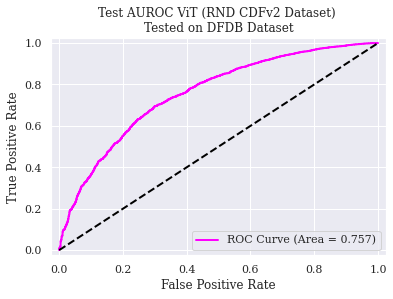

ViT (RND CDFv2 Dataset) 
Tested on AVG CDFv2 Dataset
ViT_RND
Celeb-avg-30
ViT_RND_onAVG


Found 19638 images belonging to 2 classes.


100%|██████████| 306/306 [02:54<00:00,  1.76it/s]


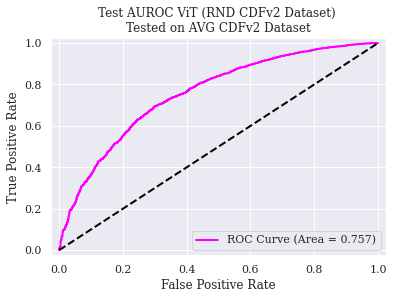

ViT (RND CDFv2 Dataset) 
Tested on RND CDFv2 Dataset
ViT_RND
Celeb-rnd-30
ViT_RND_onRND


Found 19638 images belonging to 2 classes.


100%|██████████| 306/306 [02:49<00:00,  1.81it/s]


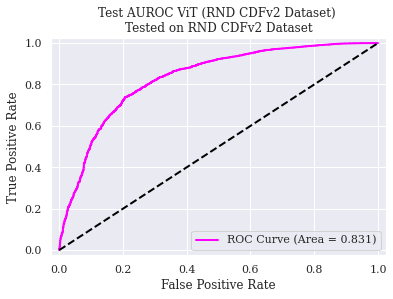

ViT (RND CDFv2 Dataset) 
Tested on AVG CDFv2 Dataset 
Running Average Evaluation
ViT_RND
Celeb-avg-30
ViT_RND_raeonAVG


Found 19638 images belonging to 2 classes.


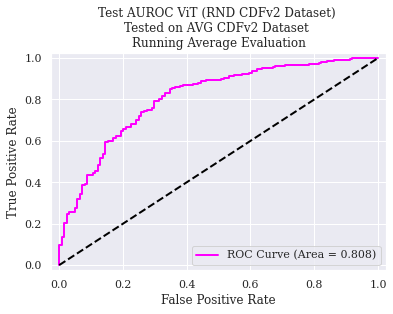

ViT (RND CDFv2 Dataset) 
Tested on RND CDFv2 Dataset 
Running Average Evaluation
ViT_RND
Celeb-rnd-30
ViT_RND_raeonRND


Found 19638 images belonging to 2 classes.


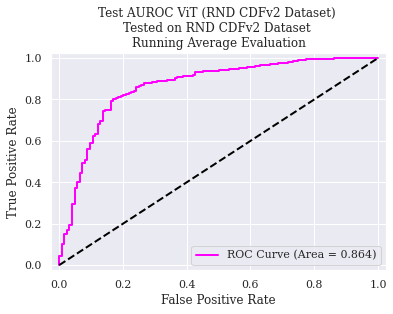

ViT (RND CDFv2 Dataset) 
Tested on AVG Deepfakes Dataset 
Running Average Evaluation
ViT_RND
Deepfakes_avg
ViT_RND_raeonDFavg


Found 42582 images belonging to 2 classes.


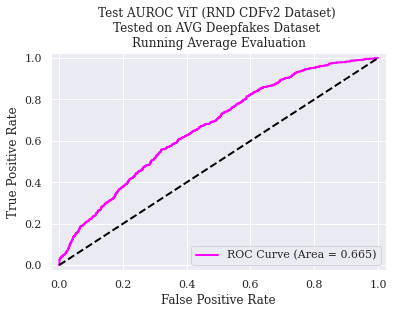

ViT (RND CDFv2 Dataset) 
Tested on AVG Deepfakes Dataset
ViT_RND
Deepfakes_avg
ViT_RND_DFavg


Found 42582 images belonging to 2 classes.


100%|██████████| 665/665 [06:00<00:00,  1.85it/s]


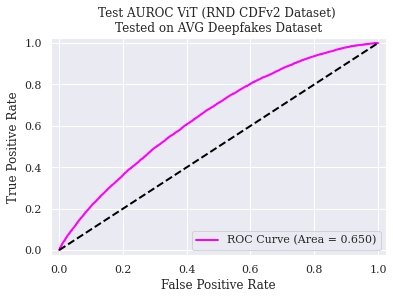

ViT (RND CDFv2 Dataset) 
Tested on RND Deepfakes Dataset 
Running Average Evaluation
ViT_RND
Deepfakes_rnd
ViT_RND_raeonDFrnd


Found 42582 images belonging to 2 classes.


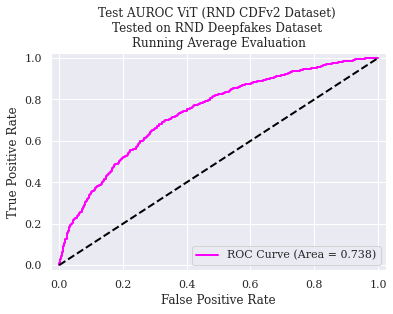

ViT (RND CDFv2 Dataset) 
Tested on RND Deepfakes Dataset
ViT_RND
Deepfakes_rnd
ViT_RND_DFrnd


Found 42582 images belonging to 2 classes.


100%|██████████| 665/665 [08:58<00:00,  1.23it/s]


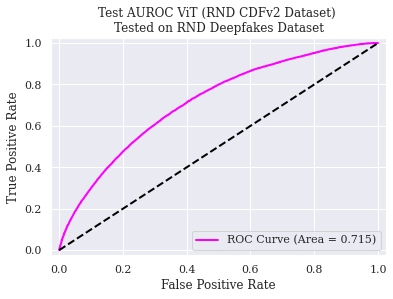

ViT (RND CDFv2 Dataset)  
Tested on AVG Face2Face Dataset  
Running Average Evaluation
ViT_RND
Face2Face_avg
ViT_RND_raeonF2Favg


Found 42587 images belonging to 2 classes.


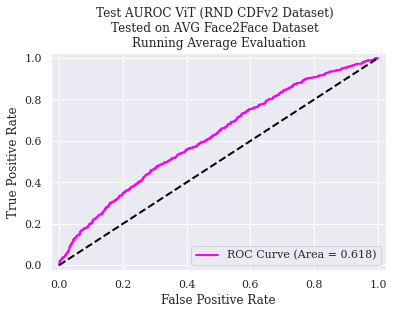

ViT (RND CDFv2 Dataset)  
Tested on AVG Face2Face Dataset
ViT_RND
Face2Face_avg
ViT_RND_F2Favg


Found 42587 images belonging to 2 classes.


100%|██████████| 665/665 [06:00<00:00,  1.85it/s]


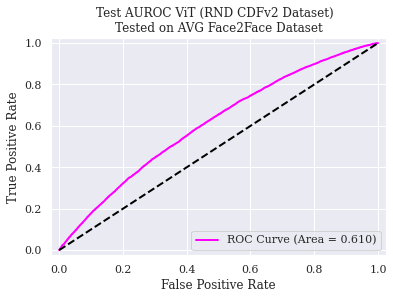

ViT (RND CDFv2 Dataset)  
Tested on RND Face2Face Dataset  
Running Average Evaluation
ViT_RND
Face2Face_rnd
ViT_RND_raeonF2Frnd


Found 42587 images belonging to 2 classes.


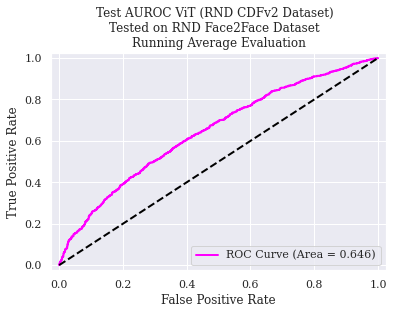

ViT (RND CDFv2 Dataset)  
Tested on RND Face2Face Dataset
ViT_RND
Face2Face_rnd
ViT_RND_F2Frnd


Found 42587 images belonging to 2 classes.


100%|██████████| 665/665 [06:02<00:00,  1.84it/s]


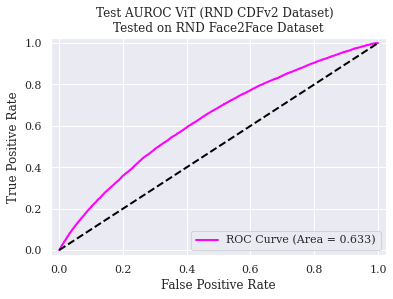

ViT (RND CDFv2 Dataset)  
Tested on AVG FaceShifter Dataset  
Running Average Evaluation
ViT_RND
FaceShifter_avg
ViT_RND_raeonFSHFTavg


Found 42603 images belonging to 2 classes.


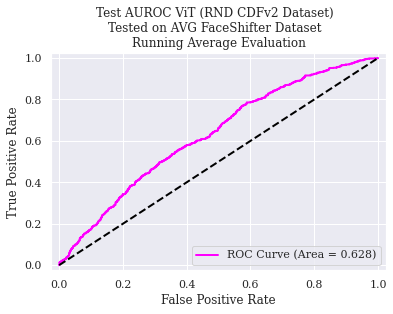

ViT (RND CDFv2 Dataset)  
Tested on AVG FaceShifter Dataset
ViT_RND
FaceShifter_avg
ViT_RND_FSHFTavg


Found 42603 images belonging to 2 classes.


100%|██████████| 665/665 [05:59<00:00,  1.85it/s]


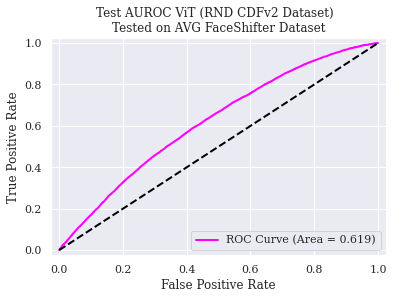

ViT (RND CDFv2 Dataset)  
Tested on RND FaceShifter Dataset  
Running Average Evaluation
ViT_RND
FaceShifter_rnd
ViT_RND_raeonFSHFTrnd


Found 42603 images belonging to 2 classes.


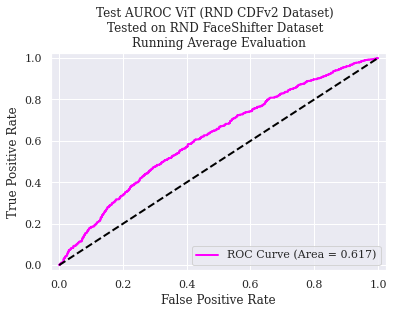

ViT (RND CDFv2 Dataset)  
Tested on RND FaceShifter Dataset
ViT_RND
FaceShifter_rnd
ViT_RND_FSHFTrnd


Found 42603 images belonging to 2 classes.


100%|██████████| 665/665 [06:03<00:00,  1.83it/s]


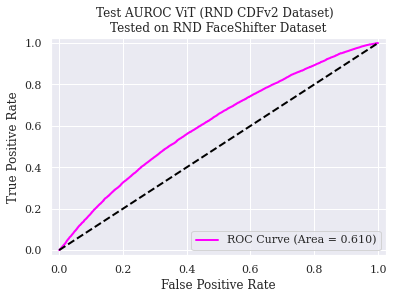

ViT (RND CDFv2 Dataset)  
Tested on AVG FaceSwap Dataset  
Running Average Evaluation
ViT_RND
FaceSwap_avg
ViT_RND_raeonFSavg


Found 39170 images belonging to 2 classes.


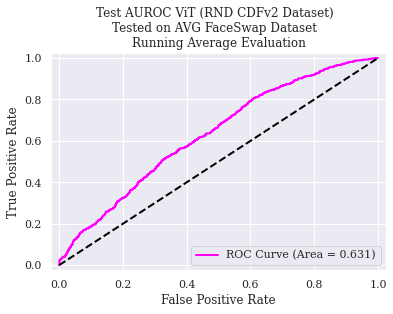

ViT (RND CDFv2 Dataset)  
Tested on AVG FaceSwap Dataset
ViT_RND
FaceSwap_avg
ViT_RND_FSavg


Found 39170 images belonging to 2 classes.


100%|██████████| 612/612 [05:30<00:00,  1.85it/s]


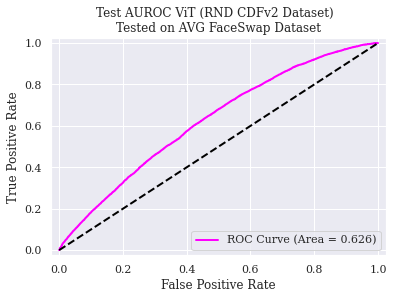

ViT (RND CDFv2 Dataset)  
Tested on RND FaceSwap Dataset  
Running Average Evaluation
ViT_RND
FaceSwap_rnd
ViT_RND_raeonFSrnd


Found 39170 images belonging to 2 classes.


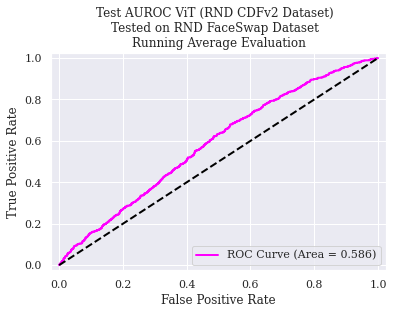

ViT (RND CDFv2 Dataset)  
Tested on RND FaceSwap Dataset
ViT_RND
FaceSwap_rnd
ViT_RND_FSrnd


Found 39170 images belonging to 2 classes.


100%|██████████| 612/612 [05:33<00:00,  1.84it/s]


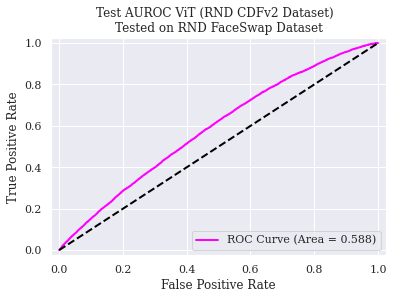

ViT (RND CDFv2 Dataset)  
Tested on AVG NeuralTextures Dataset  
Running Average Evaluation
ViT_RND
NeuralTextures_avg
ViT_RND_raeonNTavg


Found 39171 images belonging to 2 classes.


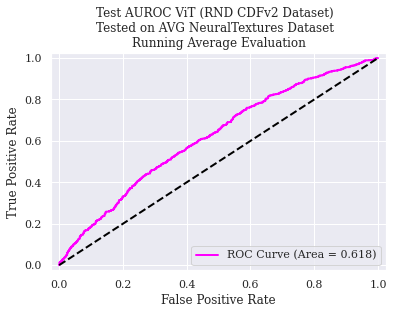

ViT (RND CDFv2 Dataset)  
Tested on AVG NeuralTextures Dataset
ViT_RND
NeuralTextures_avg
ViT_RND_NTavg


Found 39171 images belonging to 2 classes.


100%|██████████| 612/612 [05:29<00:00,  1.86it/s]


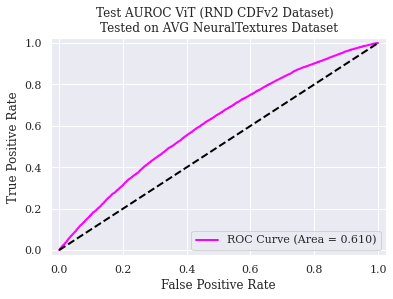

ViT (RND CDFv2 Dataset)  
Tested on RND NeuralTextures Dataset  
Running Average Evaluation
ViT_RND
NeuralTextures_rnd
ViT_RND_raeonNTrnd


Found 39163 images belonging to 2 classes.


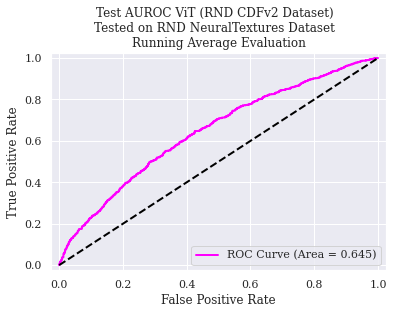

ViT (RND CDFv2 Dataset)  
Tested on RND NeuralTextures Dataset
ViT_RND
NeuralTextures_rnd
ViT_RND_NTrnd


Found 39163 images belonging to 2 classes.


100%|██████████| 611/611 [05:33<00:00,  1.83it/s]


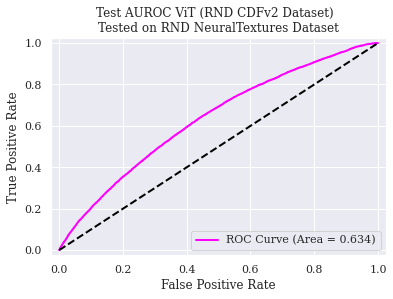

In [14]:
for experiment_name, model_name, testset_name, fname in EXPERIMENTS:
    print(experiment_name, model_name, testset_name, fname, "\n", sep="\n")
    _, _, TEST_DATASET = get_binary_testset(testset_name)

    TEST_GEN = IMG_DATAGEN.flow_from_directory(
        TEST_DATASET,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False,
        class_mode="binary",
        )

    CLASSIFIER = VIT_FE

    save_statstxt_aucplot(is_running_avg_eval="running" in experiment_name.lower())